<a href="https://colab.research.google.com/github/enacheandrei7/Indoor-Localization-Data-Science-Project/blob/main/DS105_Indoor_Localization_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Project

## 1. Importing the packages

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from keras.layers import Conv1D, Conv2D, MaxPool1D, MaxPool2D, Flatten, Dense

## 2. Importing the data

* Dataset: UJIIndoorLoc (https://archive.ics.uci.edu/ml/datasets/ujiindoorloc)
* 529 attributes and 19937 rows

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trainingData.csv")
val_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/validationData.csv")
dataset.head(5)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


## 3. Data visualization

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


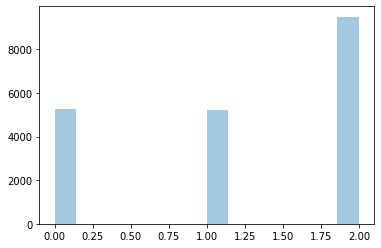

In [ ]:
# Making the bar chart for buildings
sns.distplot(dataset[['BUILDINGID']],kde=False)

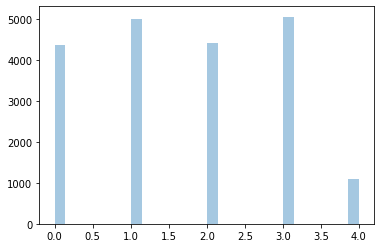

In [ ]:
# Making the bar chart for buildings
sns.distplot(dataset[['FLOOR']],kde=False)

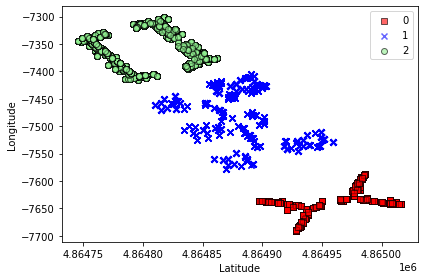

In [ ]:
# The scatter plot of the available data points
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(dataset['BUILDINGID']))])

for idx, cl in enumerate(np.unique(dataset['BUILDINGID'])):
        plt.scatter(x=dataset.loc[dataset.BUILDINGID== cl]['LATITUDE'], 
                    y=dataset.loc[dataset.BUILDINGID== cl]['LONGITUDE'],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(loc='upper right')
plt.tight_layout()



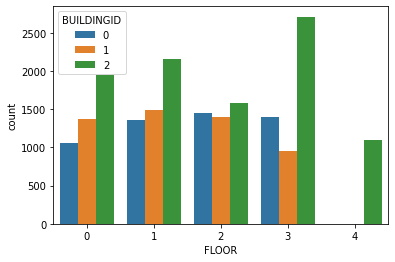

In [ ]:
# Buildings 0/1 have 4 floors, building 2 has 5
sns.countplot(x="FLOOR", hue="BUILDINGID", data=dataset,orient="v")

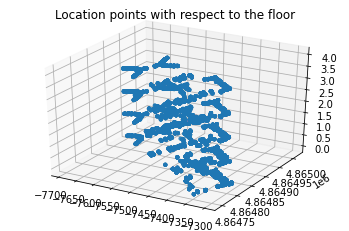

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = dataset['LONGITUDE']
ys = dataset['LATITUDE']
zs = dataset['FLOOR']
ax.scatter(xs, ys, zs, alpha=0.5, s=10,marker='o')
plt.title("Location points with respect to the floor")
plt.show()

## 4. Data Preprocessing

In [ ]:
# Removing the unused columns
dataset.drop(["SPACEID", "RELATIVEPOSITION", "USERID", "PHONEID", "TIMESTAMP"], axis=1, inplace=True)
val_dataset.drop(["SPACEID", "RELATIVEPOSITION", "USERID", "PHONEID", "TIMESTAMP"], axis=1, inplace=True)

# Creating the output (target) column
dataset['POINT'] = dataset['FLOOR'].astype(str) + dataset['BUILDINGID'].astype(str)
val_dataset['POINT'] = dataset['FLOOR'].astype(str) + dataset['BUILDINGID'].astype(str)

dataset.head(5)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,POINT
0,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-7541.2643,4.864921e+06,2,1,21
1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-7536.6212,4.864934e+06,2,1,21
2,100,100,100,100,100,100,100,-97,100,100,...,100,100,100,100,100,-7519.1524,4.864950e+06,2,1,21
3,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-7524.5704,4.864934e+06,2,1,21
4,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-7632.1436,4.864982e+06,0,0,00


In [ ]:
# Creating the independent variables (Matrix of features)
x = dataset.iloc[:, :520]
x.head(5)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
2,100,100,100,100,100,100,100,-97,100,100,...,100,100,100,100,100,100,100,100,100,100
3,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
4,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [ ]:
# dependent variable
y = dataset['POINT'].astype(float)
y.head(5)

0    21.0
1    21.0
2    21.0
3    21.0
4     0.0
Name: POINT, dtype: float64

In [ ]:
x.shape, y.shape

((19937, 520), (19937,))

In [ ]:
# splitting the dataset into train and test set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
x_train.shape, x_test.shape

((15949, 520), (3988, 520))

In [ ]:
x_train

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
7041,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
15595,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
3358,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-83,100,100,100,100
12531,100,100,100,100,100,100,100,100,100,100,...,-72,100,100,100,100,100,-73,100,100,100
18000,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,100,100,100,100,100,100,100,100,100,100,...,-87,100,100,100,100,-84,-64,100,100,100
19648,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
9845,100,100,100,100,100,100,-75,100,100,100,...,100,100,100,100,100,100,100,100,100,100
10799,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


### Remove constant features

In [ ]:
# from sklearn.feature_selection import VarianceThreshold

In [ ]:
# # Removing the low variance features, which are not changing for at least 1% of the data (~160 values/~40 values)
# # Creates a numpy.ndarray with the features data
# rm_f = VarianceThreshold(threshold=0.01)
# x_train = rm_f.fit_transform(x_train)
# x_test = rm_f.transform(x_test)

In [ ]:
# x_train.shape, x_test.shape

### Feature scaling

In [ ]:
# # Scaling the data to avoid biased outcome of predictions in terms of misclassification error and accuracy rates
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
x_train

array([[0.02743984, 0.03266366, 0.        , ..., 0.03266089, 0.01371587,
        0.        ],
       [0.02743984, 0.03266366, 0.        , ..., 0.03266089, 0.01371587,
        0.        ],
       [0.02743984, 0.03266366, 0.        , ..., 0.03266089, 0.01371587,
        0.        ],
       ...,
       [0.02743984, 0.03266366, 0.        , ..., 0.03266089, 0.01371587,
        0.        ],
       [0.02743984, 0.03266366, 0.        , ..., 0.03266089, 0.01371587,
        0.        ],
       [0.02743984, 0.03266366, 0.        , ..., 0.03266089, 0.01371587,
        0.        ]])

In [ ]:
# The data has 2 dimensions, we need to convert it to 3 dimensions
x_train.shape, x_test.shape

((15949, 520), (3988, 520))

In [ ]:
# reshape the dataset
print(x_train.shape)
x_train = x_train.reshape(15949, 520, 1)
x_test = x_test.reshape(3988, 520, 1)

(15949, 520)


In [ ]:
x_train.shape, x_test.shape

((15949, 520, 1), (3988, 520, 1))

In [ ]:
x_train.ndim

3

In [ ]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Building the model

In [ ]:
# define the model
model = tf.keras.models.Sequential()

In [ ]:
# first CNN layer
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape= (520, 1)))

# batch normalization - makes the training faster
model.add(tf.keras.layers.BatchNormalization())

# maxpool layer
model.add(tf.keras.layers.MaxPool1D(pool_size=2))

# dropout layer - regularization technique
model.add(tf.keras.layers.Dropout(0.3))

In [ ]:
# second CNN layer
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))

# batch normalization
model.add(tf.keras.layers.BatchNormalization())

# maxpool layer
model.add(tf.keras.layers.MaxPool1D(pool_size=2))

# dropout layer
model.add(tf.keras.layers.Dropout(0.5))

In [ ]:
# third CNN layer
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'))

# batch normalization
model.add(tf.keras.layers.BatchNormalization())

# maxpool layer
model.add(tf.keras.layers.MaxPool1D(pool_size=2))

# dropout layer
model.add(tf.keras.layers.Dropout(0.5))

In [ ]:
# flatten layer
model.add(tf.keras.layers.Flatten())

In [ ]:
# add the fully connected layer (first dense layer)
model.add(tf.keras.layers.Dense(units=256, activation='sigmoid'))

# dropout layer
model.add(tf.keras.layers.Dropout(0.5))

In [ ]:
# output layer - as it is multiclass classification we use softmax activation
model.add(tf.keras.layers.Dense(units=1, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 518, 32)           128       
                                                                 
 batch_normalization_3 (Batc  (None, 518, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 259, 32)          0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 259, 32)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 257, 64)           6208      
                                                                 
 batch_normalization_4 (Batc  (None, 257, 64)         

In [ ]:
# Defining the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [ ]:
# compile the model
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy', 'mean_squared_error'])


## Training the model

In [ ]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
499/499 [==============================] - 5s 8ms/step - loss: 440.9593 - accuracy: 0.0683 - mean_squared_error: 440.9593 - val_loss: 437.2121 - val_accuracy: 0.0700 - val_mean_squared_error: 437.2121
Epoch 2/10
499/499 [==============================] - 4s 7ms/step - loss: 440.9593 - accuracy: 0.0683 - mean_squared_error: 440.9593 - val_loss: 437.2121 - val_accuracy: 0.0700 - val_mean_squared_error: 437.2121
Epoch 3/10
499/499 [==============================] - 4s 8ms/step - loss: 440.9593 - accuracy: 0.0683 - mean_squared_error: 440.9593 - val_loss: 437.2121 - val_accuracy: 0.0700 - val_mean_squared_error: 437.2121
Epoch 4/10
499/499 [==============================] - 4s 7ms/step - loss: 440.9593 - accuracy: 0.0683 - mean_squared_error: 440.9593 - val_loss: 437.2121 - val_accuracy: 0.0700 - val_mean_squared_error: 437.2121
Epoch 5/10
499/499 [==============================] - 4s 7ms/step - loss: 440.9593 - accuracy: 0.0683 - mean_squared_error: 440.9593 - val_loss: 437.212